This notebook contains other pandas functionality that was not covered in the course, but that I have found useful in other cases

In [1]:
import os
import pandas as pd
import jupyter_black
import timeit

jupyter_black.load()

current_dir = os.path.dirname(os.path.abspath("__file__"))

### Set file path to datasets

In [2]:
pokemon_path = os.path.join(current_dir, "data", "pokemon.csv")
google_path = os.path.join(current_dir, "data", "google_stock_price.csv")
nba_path = os.path.join(current_dir, "data", "nba.csv")
revenue_path = os.path.join(current_dir, "data", "revenue.csv")
bond_path = os.path.join(current_dir, "data", "jamesbond.csv")
chicago_path = os.path.join(current_dir, "data", "chicago.csv")
salesmen_path = os.path.join(current_dir, "data", "salesmen.csv")
foods_path = os.path.join(current_dir, "data", "foods.csv")

bond = pd.read_csv(bond_path, index_col="Film")

,Open,High,Low,Close,Volume
Date,,,,,
2023-03-09,153.559,154.5350,150.225,150.59,53833582.0
2023-03-08,152.810,153.4700,151.830,152.87,47204791.0
2023-03-07,153.700,154.0299,151.130,151.60,56182028.0


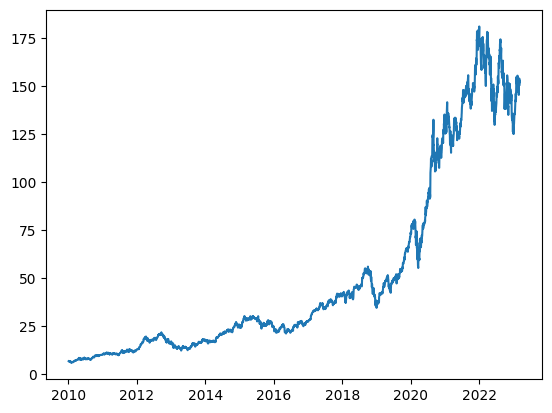

In [3]:
from pandas_datareader import data
import matplotlib.pyplot as plt

stocks = data.DataReader(
    name="AAPL", data_source="stooq", start="2010-01-01", end="2023-03-09"
)

display(stocks.head(3))

x = stocks.index
y = stocks.Close
plt.plot(x, y)
plt.show()

### The `.applymap()` and `map()` methods

This method applies a function that accepts and returns a scalar to every element of a DataFrame.

`applymap()` has been depricated. Use `map()` instead.

In [4]:
stocks.map(lambda cell: cell > 151).head(3)

,Open,High,Low,Close,Volume
Date,,,,,
2023-03-09,True,True,False,False,True
2023-03-08,True,True,True,True,True
2023-03-07,True,True,True,True,True


### `map()` vs `apply()`

`map()` is used to apply a function to each cell of a dataframe, and returns a dataframe with the same dimension as the input.

`apply()` is used to apply a function to one axis of the dataframe, and returns a series: Applyies a function to each row/column to the dataframe and returns one value for each row/column in the returned series. 

In summary, the function used as input in map takes a cell as input and returns a new value for that cell, while the function used as input in apply takes as input a row or column and returns a single value for that row/column. 

`apply()` aggregates over one axis of the dataframe, while `map()` applies a function to each cell. 

I can't come up with times that I have used apply to perform column-wise operations, just row-wise. 

Column-wise: `df.apply(f, axis = 0)`
Row-wise:    `df.apply(f, axis = 1)`

When applied to a pandas series, it seems to me like there is no difference in `map()` and `apply()`, but `map()` looks to be slightly faster. 
There is a difference when considering different types of input. If the input is a function, then there is no difference, but `map()` can take a dictionary as input as well, which will return in error for `apply()`.

In [5]:
def f(cell):
    if isinstance(cell, str):
        return cell
    if isinstance(cell, int):
        if cell <= 1975:
            return "old"
        return cell
    if isinstance(cell, float):
        return cell * 2


bond.map(f).sample(5)

,Year,Actor,Director,Box Office,Budget,Bond Actor Salary
Film,,,,,,
The Man with the Golden Gun,old,Roger Moore,Guy Hamilton,668.0,55.4,NaN
Moonraker,1979,Roger Moore,Lewis Gilbert,1070.0,183.0,NaN
The World Is Not Enough,1999,Pierce Brosnan,Michael Apted,879.0,316.6,27.0
Quantum of Solace,2008,Daniel Craig,Marc Forster,1028.4,362.8,16.2
Thunderball,old,Sean Connery,Terence Young,1696.2,83.8,9.4


In [6]:
# apply a function on each row
def f(row):
    if row["Year"] < 1975:
        return "Good"
    if row["Actor"] == "Daniel Craig":
        return "Good"
    return "Bad"


bond.apply(f, axis=1).sample(4)

Film
From Russia with Love    Good
Licence to Kill           Bad
Octopussy                 Bad
Spectre                  Good
dtype: object

In [7]:
# apply a function on each column
def f(col):
    return min(col)


bond.apply(f, axis=0)

Year                         1962
Actor                Daniel Craig
Director             Guy Hamilton
Box Office                  250.9
Budget                        7.0
Bond Actor Salary             0.6
dtype: object

In [8]:
# Use map/apply on a series which results in identical results
bond["Box Office"].map(lambda x: x * 2)
bond["Box Office"].apply(lambda x: x * 2);

### Performance comparison when perforing string operation on each element in a Series

For some reason, it is almost twice as fast to use `.map()` together with a string-function than to do the same with the built in `.str` attribute.

This is strange, because `.str` should be vectorized, while `map()` is not.

[Relevant link](https://www.gresearch.com/news/faster-string-processing-in-pandas/)

In [9]:
%%timeit
bond["Director"].map(lambda x: x.startswith("T"))

11.9 μs ± 146 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [10]:
%%timeit
bond["Director"].str.startswith("T")

20 μs ± 84.9 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [11]:
%%timeit
bond["Actor"].str.strip().str.lower().str.lstrip("s")

63.3 μs ± 665 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [12]:
%%timeit


def f(cell):
    return cell.strip().lower().lstrip("s")


bond["Actor"].map(f)

13.5 μs ± 126 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [13]:
%%timeit
bond["Actor"].map(lambda cell: cell.strip().lower().lstrip("s"))

13.5 μs ± 43.2 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [38]:
%%timeit


def f(cell):
    return cell.strip().lower().lstrip("s")


bond["Actor"].map(f)

13.9 μs ± 176 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


### `map()`, `all()`, `any()`

`all()` and `any()` are applied on a dataframe with all boolean values.

`all()`: Returns true if all elements in a row/columns holds the value `True`

`any()`: Returns true if one or more elements in a row/columns holds the value `True`

In [14]:
bond.map(lambda x: isinstance(x, str) and x != "" and x[0].isalpha()).all()
bond.map(lambda x: isinstance(x, str)).all(axis=0)
bond.map(lambda x: isinstance(x, str)).all(axis=1);

In [15]:
# Get name of type in each cell
bond.map(lambda x: type(x).__name__).head(3)

,Year,Actor,Director,Box Office,Budget,Bond Actor Salary
Film,,,,,,
Dr. No,int,str,str,float,float,float
From Russia with Love,int,str,str,float,float,float
Goldfinger,int,str,str,float,float,float


### `pd.to_numeric()`, `pd.to_datetime()`, `notna()`

In [16]:
# The below code casts all values to numeric if able, otherwise it is casted to NaN (becuse of errors="coerce")
s = pd.Series(["1", "1.1", "a"])
# The two lines below do the same thing, but the second is much faster. However, only the first one can be applied to a DataFrame.
s.apply(pd.to_numeric, errors="coerce")
pd.to_numeric(s, errors="coerce")

0    1.0
1    1.1
2    NaN
dtype: float64

In [17]:
# The below code checks whether all values can sucessfully be cased to numeric
s.apply(pd.to_numeric, errors="coerce").notna().all()

False

In [18]:
# The below code casts all values to datetime if able, otherwise it is casted to NaT (becuse of errors="coerce")
s = pd.Series(["05.12.1989", "5.12.89", "12/5/1989"])
display(pd.to_datetime(s, errors="coerce"))
display(pd.to_datetime(s, errors="coerce", format="%d.%m.%Y"))
display(pd.to_datetime(s, errors="coerce", format="%d.%m.%y"))
display(pd.to_datetime(s, errors="coerce", format="%m/%d/%Y"))

0   1989-05-12
1          NaT
2          NaT
dtype: datetime64[ns]

0   1989-12-05
1          NaT
2          NaT
dtype: datetime64[ns]

0          NaT
1   1989-12-05
2          NaT
dtype: datetime64[ns]

0          NaT
1          NaT
2   1989-12-05
dtype: datetime64[ns]

### Revert column/row order with `.iloc`

In [19]:
# Revert row-order
bond.iloc[::-1, :]
# Revert column-order
bond.iloc[:, ::-1];

### Merge on idex

In [20]:
pd.merge(bond, bond, left_index=True, right_index=True);

### Different ways to create a DataFrame from Python-objects

In [21]:
# Create dataframe from list of lists: Each list becomes a row.
data = [["a", "b", "c"], [1, 2, 3]]
colnames = ["col_1", "col_2", "col_3"]
pd.DataFrame(data=data, columns=colnames)


# Create dataframe from a dict of lists the keys become column names and the lists become columns
my_dict = {"col_1": ["a", 1], "col_2": ["b", 2], "col_3": ["c", 3]}
pd.DataFrame(data=my_dict)

,col_1,col_2,col_3
0,a,b,c
1,1,2,3


### `replace()`

In [22]:
# replace() can be used directly on a DataFrame without worrying about the dtypes
# It is much faster than doing the same with the `.map()` function
bond.replace("Roger Moore", "UNKNOWN")
bond.replace(7, "UNKNOWN");

In [23]:
bond

,Year,Actor,Director,Box Office,Budget,Bond Actor Salary
Film,,,,,,
Dr. No,1962,Sean Connery,Terence Young,448.8,7.0,0.6
From Russia with Love,1963,Sean Connery,Terence Young,543.8,12.6,1.6
Goldfinger,1964,Sean Connery,Guy Hamilton,820.4,18.6,3.2
Thunderball,1965,Sean Connery,Terence Young,848.1,41.9,4.7
Casino Royale,1967,David Niven,Ken Hughes,315.0,85.0,NaN
You Only Live Twice,1967,Sean Connery,Lewis Gilbert,514.2,59.9,4.4
On Her Majesty's Secret Service,1969,George Lazenby,Peter R. Hunt,291.5,37.3,0.6
Diamonds Are Forever,1971,Sean Connery,Guy Hamilton,442.5,34.7,5.8
Live and Let Die,1973,Roger Moore,Guy Hamilton,460.3,30.8,NaN


#### `idxmax()`: Return the row-label with the maximum value

In [24]:
idx = bond["Box Office"].idxmax()
bond.loc[idx]

Year                         2012
Actor                Daniel Craig
Director               Sam Mendes
Box Office                  943.5
Budget                      170.2
Bond Actor Salary            14.5
Name: Skyfall, dtype: object

### `memory_usage()`

In [25]:
bond.memory_usage(deep=True).sum()

6769

### `select_dtypes()`

In [26]:
bond.select_dtypes(include=["object"])
bond.select_dtypes(include=["number"]).head(3)

,Year,Box Office,Budget,Bond Actor Salary
Film,,,,
Dr. No,1962,448.8,7.0,0.6
From Russia with Love,1963,543.8,12.6,1.6
Goldfinger,1964,820.4,18.6,3.2


### `get_loc()`

In [27]:
# Get integer location, slice or boolean mask for requested label.
bond.columns.get_loc("Box Office")

3

### `slice()`

In [40]:
# Note that doing string operation with map() probably will be faster than slice()
bond["Actor"].str.slice(2, 4);

### Aggregate by concatenate strings

In [49]:
bond.groupby("Actor")["Director"].agg(lambda s: s.str.cat(sep="\n"))

Actor
Daniel Craig      Martin Campbell\nMarc Forster\nSam Mendes\nSam...
David Niven                                              Ken Hughes
George Lazenby                                        Peter R. Hunt
Pierce Brosnan    Martin Campbell\nRoger Spottiswoode\nMichael A...
Roger Moore       Guy Hamilton\nGuy Hamilton\nLewis Gilbert\nLew...
Sean Connery      Terence Young\nTerence Young\nGuy Hamilton\nTe...
Timothy Dalton                                 John Glen\nJohn Glen
Name: Director, dtype: object

### Aggregate by concatenate to list

In [53]:
bond.groupby("Actor")["Director"].agg(list)

Actor
Daniel Craig      [Martin Campbell, Marc Forster, Sam Mendes, Sa...
David Niven                                            [Ken Hughes]
George Lazenby                                      [Peter R. Hunt]
Pierce Brosnan    [Martin Campbell, Roger Spottiswoode, Michael ...
Roger Moore       [Guy Hamilton, Guy Hamilton, Lewis Gilbert, Le...
Sean Connery      [Terence Young, Terence Young, Guy Hamilton, T...
Timothy Dalton                               [John Glen, John Glen]
Name: Director, dtype: object

### `pd.json_normalize`

Turn JSON-data into a flat table

In [54]:
# Example JSON data
data = [
    {
        "id": 1,
        "name": "John Doe",
        "address": {"city": "New York", "zipcode": "10001"},
        "hobbies": ["reading", "hiking"],
    },
    {
        "id": 2,
        "name": "Jane Smith",
        "address": {"city": "Los Angeles", "zipcode": "90001"},
        "hobbies": ["painting", "swimming"],
    },
]

pd.json_normalize(data)

,id,name,hobbies,address.city,address.zipcode
0,1,John Doe,"[reading, hiking]",New York,10001
1,2,Jane Smith,"[painting, swimming]",Los Angeles,90001
